# Minicompetition Project
## Rossman 6 month sales Prediction
Here, we will go through a data challenge using data predicting Sales for Rossman. 



In [1]:
import numpy as np
import pandas as pd
# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import plotly
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from math import sqrt
import category_encoders as ce
import pickle

## 1. Initial Data Understanding
Here, we get to know our data and try to figure out next steps for modelling.

A goal in this step is to get to know what types of data cleaning, preparation and encoding we need to do in order to prepare our data for inclusion in a model.

Since we are predicting price, this is a supervised regression problem.

In [5]:
holdout = pd.read_csv('./data/holdout.csv')
train = pd.read_csv('./data/train.csv')
store = pd.read_csv('./data/store.csv')

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2014-08-01,371,5,7195,550,1,1,0,1
1,2014-08-01,372,5,9525,815,1,1,0,1
2,2014-08-01,373,5,5621,357,1,1,0,1
3,2014-08-01,380,5,16933,1512,1,1,0,1
4,2014-08-01,374,5,7828,878,1,1,0,1


In [100]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerAverage'],
      dtype='object')

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [7]:
bins=[200,300,350,400,450,500,550,600,700,800,900,1200,1500,3500]
CustomerTraffic = pd.DataFrame(train.groupby('Store')['Customers'].mean())
CustomerTraffic.Customers.describe()

CustomerTraffic['CustomerTraffic'] = pd.cut(CustomerTraffic['Customers'], bins)

CustomerTraffic.drop(columns='Customers', inplace=True)

In [102]:
holdout['CustomerAverage'] = holdout['Sales']/holdout['Customers']

combined2=pd.merge(pd.merge(pd.merge(holdout, CustomerTraffic, on='Store', how='left'), CustomerCat, on='Store', how='left'), store, on='Store', how='left')
combined2.shape

combined2.rename(columns={"CustomerAverage_y": "CustomerAverage"}, inplace=True)
fillna_promo(combined2, promo_cols)

fillna_rest(combined2)

combined2.dropna(inplace=True)

data2 = combined2.loc[~combined2.loc[:, "Sales"].isnull()]

dropna_auto(data2, list(data2.columns), 55)
null_percentage(data2, list(data2.columns))
data2.PromoInterval.replace(0,'0', inplace=True)
data2.drop(columns='Customers', inplace=True)

In [ ]:
combined.StateHoliday.replace(0,'0', inplace=True)
combined.drop(columns='CustomerAverage', inplace=True)

In [8]:
train['CustomerAverage'] = train['Sales']/train['Customers']

train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CustomerAverage
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118


In [9]:
bins2 = [0,2,4,6,8,10,15,18,25,40,65]
CustomerCat = pd.DataFrame(train.groupby('Store')['CustomerAverage'].mean())
CustomerCat['CustomerCategory'] = pd.cut(CustomerCat['CustomerAverage'], bins2)
CustomerCat.drop(columns='CustomerAverage', inplace=True)

In [10]:
CustomerCat.CustomerCategory

Store
1        (8, 10]
2        (8, 10]
3        (8, 10]
4         (6, 8]
5        (8, 10]
          ...   
1111    (10, 15]
1112    (10, 15]
1113     (8, 10]
1114      (6, 8]
1115    (10, 15]
Name: CustomerCategory, Length: 1115, dtype: category
Categories (10, interval[int64]): [(0, 2] < (2, 4] < (4, 6] < (6, 8] ... (15, 18] < (18, 25] < (25, 40] < (40, 65]]

In [11]:
combined=pd.merge(pd.merge(pd.merge(train, CustomerTraffic, on='Store', how='left'), CustomerCat, on='Store', how='left'), store, on='Store', how='left')
combined.shape

combined.rename(columns={"CustomerAverage_y": "CustomerAverage"}, inplace=True)
combined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CustomerAverage,...,CustomerCategory,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,...,"(8, 10]",c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400,...,"(8, 10]",a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675,...,"(8, 10]",a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457,...,"(6, 8]",c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118,...,"(8, 10]",a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
combined.StateHoliday.replace(0,'0', inplace=True)

In [13]:
combined.CustomerCategory.nunique()

6

In [14]:
combined.drop(columns='CustomerAverage', inplace=True)

In [15]:
combined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [16]:
for i in combined.columns:
    print(i)
    print(combined[i].value_counts()[:3], combined[i].value_counts()[-3:] )

Store
1023    942
666     942
675     942
Name: Store, dtype: int64 903    758
904    758
512    758
Name: Store, dtype: int64
DayOfWeek
5    145845
4    145845
3    145665
Name: DayOfWeek, dtype: int64 7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64
Date
2014-05-03    1115
2013-02-09    1115
2013-05-23    1115
Name: Date, dtype: int64 2014-09-11    935
2014-12-26    935
2014-09-13    935
Name: Date, dtype: int64
Sales
0       172871
5674       215
5558       197
Name: Sales, dtype: int64 26167    1
17971    1
22905    1
Name: Sales, dtype: int64
Customers
0      172869
560      2414
576      2363
Name: Customers, dtype: int64 4160    1
3972    1
3485    1
Name: Customers, dtype: int64
Open
1    844392
0    172817
Name: Open, dtype: int64 1    844392
0    172817
Name: Open, dtype: int64
Promo
0    629129
1    388080
Name: Promo, dtype: int64 0    629129
1    388080
Name: Promo, dtype: int64
StateHoliday
0    986159
a     20260
b      6690
Name: StateHoliday, dtype: in

KeyError: 3

In [ ]:
combined.describe().T

In [ ]:
msno.bar(combined, color='red')

In [17]:
def compute_rmse(actual, prediction):
    """
    Computs RMSE (root mean squared error) between predictions from a model
    and the actual values of the target variable.
    """
    
    rmse = sqrt(mean_squared_error(actual, prediction))
    
    # rounding to 2 decimal places
    print('RMSE is ', round(rmse,2))
    
    return rmse

# def mean_encode(data, col, on):
#     group = data.groupby(col).mean()
#     mapper = {k: v for k, v in zip(group.index, group.loc[:, on].values)}

#     data.loc[:, col] = data.loc[:, col].replace(mapper)
#     data.loc[:, col].fillna(value=np.mean(data.loc[:, col]), inplace=True)

#     return data

def mean_encode(data, col, on):
    for i in col:
        group = data.groupby(i).mean()
        data.loc[:, i+'-original'] = data.loc[:, i]
        mapper = {k: v for k, v in zip(group.index, group.loc[:, on].values)}

        data.loc[:, i] = data.loc[:, i].replace(mapper)
        data.loc[:, i].fillna(value=np.mean(data.loc[:, i]), inplace=True)
        return data.loc[:, i]

        for col in columns_to_mean_encode:
            data.loc[:, col] = mean_encode(data.copy(), col, "Sales")
        
#Label Encoding the color column
from sklearn.preprocessing import LabelEncoder
def label_encoder(df, cols):
    for i in cols:        
        le = LabelEncoder()  #instantiate the Label Encoder
        df[i] = le.fit_transform(df[i])

#it's ideal to always instantiate new LabelEncoders for different columns

def time_decompose(df, colname):
    for i in colname:
        df['Year'] = pd.DatetimeIndex(df[colname]).year
        df['Month'] = pd.DatetimeIndex(df[colname]).month
        df['DayofMonth'] = pd.DatetimeIndex(df[colname]).day        
        
        
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

def remove_outliers(df, colnames):
    for col in colnames:
        avg = df[col].mean()
        std = df[col].std()
        low = avg - 3 * std
        high = avg + 3 * std
        df = df[df[col].between(low, high, inclusive=True)]
    return df


def dropna_auto(df, cols, thresh):
    """
    Drop nulls for columns having null percentage less than the specified threshold
    """
    for i in cols:
        if df[i].isnull().sum()*100/df.shape[0] < thresh:
            df.dropna(subset=[i], inplace=True)
        else:
            continue
            
def correlation(dataset, threshold):
    """ Removes all columns with internal correlation with each other if they are than the specified 'threshold' """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold or corr_matrix.iloc[i, j] <= -threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(dataset.columns)
    

def null_percentage(df, cols):
    columns_with_nulls = []
    for column in cols:
        if df.loc[:, column].isnull().any():
            columns_with_nulls.append(column)

    for column in columns_with_nulls:
        percent_missing = round(((df.loc[df.loc[:, column].isnull()].shape[0] / df.shape[0]) * 100), 4)
        print("Column {} has {}% missing values \n".format(column, percent_missing))


In [18]:
combined.shape
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Store                      1017209 non-null  int64   
 1   DayOfWeek                  1017209 non-null  int64   
 2   Date                       1017209 non-null  object  
 3   Sales                      1017209 non-null  int64   
 4   Customers                  1017209 non-null  int64   
 5   Open                       1017209 non-null  int64   
 6   Promo                      1017209 non-null  int64   
 7   StateHoliday               1017209 non-null  object  
 8   SchoolHoliday              1017209 non-null  int64   
 9   CustomerTraffic            1016267 non-null  category
 10  CustomerCategory           1017209 non-null  category
 11  StoreType                  1017209 non-null  object  
 12  Assortment                 1017209 non-null  object  
 1

In [19]:
promo_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
def fillna_promo(df, cols):
    for i in promo_cols:
            df[i].fillna('noPromo', inplace=True)

fillna_promo(combined, promo_cols)

In [20]:
# fill the missing values assuming that year was old enough that person filling form doesn't 
def fillna_rest(df):
    try:
        df.CompetitionOpenSinceMonth.fillna(combined.CompetitionOpenSinceMonth.median(), inplace=True)
    except:
        pass
    try:
        df.CompetitionOpenSinceYear.fillna(2005.0, inplace=True)
    except:
        pass
    try:
        df.CompetitionDistance.fillna(combined.CompetitionDistance.median(), inplace=True)
    except:
        pass
        
fillna_rest(combined)

In [21]:
combined.dropna(inplace=True)

In [22]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016267 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Store                      1016267 non-null  int64   
 1   DayOfWeek                  1016267 non-null  int64   
 2   Date                       1016267 non-null  object  
 3   Sales                      1016267 non-null  int64   
 4   Customers                  1016267 non-null  int64   
 5   Open                       1016267 non-null  int64   
 6   Promo                      1016267 non-null  int64   
 7   StateHoliday               1016267 non-null  object  
 8   SchoolHoliday              1016267 non-null  int64   
 9   CustomerTraffic            1016267 non-null  category
 10  CustomerCategory           1016267 non-null  category
 11  StoreType                  1016267 non-null  object  
 12  Assortment                 1016267 non-null  object  
 1

In [23]:
combined.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1016267.0,558.444029,322.057466,1.0,280.0,559.0,838.0,1115.0
DayOfWeek,1016267.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1016267.0,5777.026447,3849.982156,0.0,3733.0,5747.0,7858.0,41551.0
Customers,1016267.0,633.548243,464.426392,0.0,405.0,610.0,837.0,7388.0
Open,1016267.0,0.830108,0.375538,0.0,1.0,1.0,1.0,1.0
Promo,1016267.0,0.381514,0.485758,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1016267.0,0.178622,0.383036,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1016267.0,5426.058516,7709.349709,20.0,710.0,2330.0,6880.0,75860.0
CompetitionOpenSinceMonth,1016267.0,7.465700,2.674927,1.0,6.0,8.0,9.0,12.0
CompetitionOpenSinceYear,1016267.0,2007.513032,5.239827,1900.0,2005.0,2006.0,2011.0,2015.0


In [24]:
# getting number of rows with null price.
# since we are trying to predict price, we will need to drop these. 
print("Total number of rows in data set is: ", combined.shape[0])
print("Number of rows with missing Sales is: ",  combined.loc[combined.loc[:, "Sales"].isnull()].shape[0])

Total number of rows in data set is:  1016267
Number of rows with missing Sales is:  0


## 2. Data Cleaning (and further understanding & analysis)
Now that we have a very rough understanding of our data, we can move on to dealing with more of the null values.

Data cleaning, understanding, and analysis are iterative processes. Often times, as we do analysis, we will find columns or rows that need to be cleaned, and as we are cleaning, we may get ideas for additional analysis we want to do. 

In [25]:
data = combined.loc[~combined.loc[:, "Sales"].isnull()]

In [26]:
data.shape

(1016267, 20)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016267 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Store                      1016267 non-null  int64   
 1   DayOfWeek                  1016267 non-null  int64   
 2   Date                       1016267 non-null  object  
 3   Sales                      1016267 non-null  int64   
 4   Customers                  1016267 non-null  int64   
 5   Open                       1016267 non-null  int64   
 6   Promo                      1016267 non-null  int64   
 7   StateHoliday               1016267 non-null  object  
 8   SchoolHoliday              1016267 non-null  int64   
 9   CustomerTraffic            1016267 non-null  category
 10  CustomerCategory           1016267 non-null  category
 11  StoreType                  1016267 non-null  object  
 12  Assortment                 1016267 non-null  object  
 1

In [28]:
null_percentage(data, list(data.columns))

Some of the columns which contain a very high amount of missing values, like promotional columns can likely be filled with strings 'nopromo' for one hot encoding. 



Building Area concerns the square meters of the property. It's sad that this one contains such a high percentage of missing values, as that would likely give more information than just the number of rooms.

In our first iteration, since we are trying to get a model trained quickly, we will have to leave this one out, or get creative with another way of filling it in. For example, we could fill it in with the average building area from that neighborhood or postcode.

In [29]:
dropna_auto(data, list(data.columns), 55)
null_percentage(data, list(data.columns))

In [30]:
null_percentage(data, list(data.columns))

In [31]:
data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
CustomerTraffic              0
CustomerCategory             0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [32]:
# shape before dropping few nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016267 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Store                      1016267 non-null  int64   
 1   DayOfWeek                  1016267 non-null  int64   
 2   Date                       1016267 non-null  object  
 3   Sales                      1016267 non-null  int64   
 4   Customers                  1016267 non-null  int64   
 5   Open                       1016267 non-null  int64   
 6   Promo                      1016267 non-null  int64   
 7   StateHoliday               1016267 non-null  object  
 8   SchoolHoliday              1016267 non-null  int64   
 9   CustomerTraffic            1016267 non-null  category
 10  CustomerCategory           1016267 non-null  category
 11  StoreType                  1016267 non-null  object  
 12  Assortment                 1016267 non-null  object  
 1

In the end, we only dropped 3 rows.
This likely means that many of the null values for different columns were in the same row.

In [33]:
# updating our "columns_with_nulls" list
columns_with_nulls = []
for column in data.columns:
    if data.loc[:, column].isnull().any():
        columns_with_nulls.append(column)
columns_with_nulls

[]

In [34]:
percent_columns_with_nulls = (len(columns_with_nulls) / len(data.columns)) * 100
print("Percentage of columns still containing missing values: {}".format(percent_columns_with_nulls))

Percentage of columns still containing missing values: 0.0


For our first model iteration, we will drop the roungly 1/3 of our columns that still contain null values. 

## 2.1  Encoding and Train-Test Split:
To prevent data leakage, we will do our train/test split now, to hold out one part of the dataset completely away as the holdout set.

In [35]:
data = data.drop(columns=columns_with_nulls)
data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [36]:
data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [37]:
data.PromoInterval.replace(0,'0', inplace=True)

In [38]:
data.nunique()

Store                         1114
DayOfWeek                        7
Date                           942
Sales                        21731
Customers                     4085
Open                             2
Promo                            2
StateHoliday                     4
SchoolHoliday                    2
CustomerTraffic                 13
CustomerCategory                 6
StoreType                        4
Assortment                       3
CompetitionDistance            654
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 25
Promo2SinceYear                  8
PromoInterval                    4
dtype: int64

In [39]:
data.drop(columns='Open', inplace=True)

In [40]:
data.Promo2.value_counts()

1    509178
0    507089
Name: Promo2, dtype: int64

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016267 entries, 0 to 1017208
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Store                      1016267 non-null  int64   
 1   DayOfWeek                  1016267 non-null  int64   
 2   Date                       1016267 non-null  object  
 3   Sales                      1016267 non-null  int64   
 4   Customers                  1016267 non-null  int64   
 5   Promo                      1016267 non-null  int64   
 6   StateHoliday               1016267 non-null  object  
 7   SchoolHoliday              1016267 non-null  int64   
 8   CustomerTraffic            1016267 non-null  category
 9   CustomerCategory           1016267 non-null  category
 10  StoreType                  1016267 non-null  object  
 11  Assortment                 1016267 non-null  object  
 12  CompetitionDistance        1016267 non-null  float64 
 1

In [42]:
data.loc[data['Sales']==0].any().sum()

18

In [43]:
data = data[data['Sales'] > 0]

# Model Building with PyCaret

In [214]:
!pip install pycaret

In [45]:
from pycaret.regression import *

In [48]:
data.drop(columns='Customers', inplace=True)



In [58]:
data.head()

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,CustomerTraffic,CustomerCategory,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,1,0,1,"(450, 500]","(8, 10]",c,a,1270.0,9.0,2008.0,0,noPromo,noPromo,noPromo
1,2,5,2015-07-31,6064,1,0,1,"(450, 500]","(8, 10]",a,a,570.0,11.0,2007.0,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,1,0,1,"(600, 700]","(8, 10]",a,a,14130.0,12.0,2006.0,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1,0,1,"(900, 1200]","(6, 8]",c,c,620.0,9.0,2009.0,0,noPromo,noPromo,noPromo
4,5,5,2015-07-31,4822,1,0,1,"(400, 450]","(8, 10]",a,a,29910.0,4.0,2015.0,0,noPromo,noPromo,noPromo


In [72]:
#Pre-Process data

reg1 = setup(data = data.sample(200000),
             session_id=42,
             train_size = 0.70,
             target = 'Sales',
             #high_cardinality_features = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday','SchoolHoliday', 'StoreType', 'Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2','Year', 'Month'],
             #numeric_imputation = 'median',
             #categorical_imputation = 'mode',
             feature_selection = True,
             normalize = True, 
             transformation = True, 
             #transform_target = True,
             ignore_low_variance = True,
             remove_multicollinearity = True, 
             multicollinearity_threshold = 0.80, 
             #polynomial_features = True,
             #trigonometry_features = False,
             #polynomial_degree = 2,
             #polynomial_threshold = 0.9,
#              numeric_features = 'CompetitionDistance' ,
#              categorical_features = ['StateHoliday','CustomerCategory', 'CustomerTraffic', 'DayOfWeek', 'DayOfWeek', 'Promo', 'StoreType','Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
#              ignore_features = 'Store', 
#              date_features='Date',
             log_experiment = True, 
             verbose = True,
             experiment_name = 'regression1'
             )

,Description,Value
0,session_id,42
1,Target,Sales
2,Original Data,"(200000, 18)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,12
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(139999, 81)"


In [73]:
get_config('X_train')

,Date_weekday_6,Promo2SinceWeek_37.0,Promo2SinceWeek_13.0,CustomerTraffic_(800 900,Promo2SinceWeek_45.0,Date_weekday_5,Promo2SinceWeek_31.0,CompetitionDistance,Promo2SinceWeek_27.0,Promo2SinceWeek_40.0,...,Promo2SinceYear_2015.0,Promo2SinceWeek_10.0,Promo2SinceWeek_9.0,PromoInterval_MarJunSeptDec,Date_month_9,CustomerCategory_(15 18,Date_month_11,DayOfWeek_3,CustomerTraffic_(400 450,Date_month_4
430073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.930743,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
915726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.925915,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
112607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.013912,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
47711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.276211,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275624,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.191831,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.280865,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.160685,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.591827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.525414,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [109]:
from pycaret.classification import *
clf1 = setup(data2, target = 'Class variable')

,Date,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,CustomerAverage,CustomerTraffic,CustomerCategory,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2014-08-01,371,5,1,1,0,1,13.081818,"(450, 500]","(10, 15]",d,c,1970.0,7.0,2009.0,1,45,2014,"Feb,May,Aug,Nov"
1,2014-08-01,372,5,1,1,0,1,11.687117,"(600, 700]","(10, 15]",d,c,4880.0,8.0,2010.0,1,18,2014,"Jan,Apr,Jul,Oct"
2,2014-08-01,373,5,1,1,0,1,15.745098,"(200, 300]","(10, 15]",d,c,11120.0,8.0,2005.0,1,22,2012,"Jan,Apr,Jul,Oct"
3,2014-08-01,380,5,1,1,0,1,11.199074,"(900, 1200]","(10, 15]",a,a,2240.0,5.0,2013.0,1,10,2014,"Mar,Jun,Sept,Dec"
4,2014-08-01,374,5,1,1,0,1,8.915718,"(600, 700]","(8, 10]",a,a,1150.0,9.0,2007.0,0,noPromo,noPromo,noPromo


In [106]:
get_config('X_train')

,Date_weekday_6,Promo2SinceWeek_37.0,Promo2SinceWeek_13.0,CustomerTraffic_(800 900,Promo2SinceWeek_45.0,Date_weekday_5,Promo2SinceWeek_31.0,CompetitionDistance,Promo2SinceWeek_27.0,Promo2SinceWeek_40.0,...,Promo2SinceYear_2015.0,Promo2SinceWeek_10.0,Promo2SinceWeek_9.0,PromoInterval_MarJunSeptDec,Date_month_9,CustomerCategory_(15 18,Date_month_11,DayOfWeek_3,CustomerTraffic_(400 450,Date_month_4
430073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.930743,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
915726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.925915,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
112607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.013912,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
47711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.276211,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275624,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.191831,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.280865,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.160685,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.591827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.525414,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [74]:
combined_nopromo_processed_x_train = get_config('X_train')
combined_nopromo_processed_y_train = get_config('y_train')
combined_nopromo_processed_x_test = get_config('X_test')
combined_nopromo_processed_y_test = get_config('y_test')

In [75]:
get_config('prep_pipe')

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='Sales',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                 Advanced_Feature_Selection_Classic(ml_usecase='regression',
                                                    n_jobs=-1, random_state=42,
                                                    subclass='binary',
                                                    target='Sales',
                             

In [76]:
# Screen for algorithm
best = compare_models(fold = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,768.6674,1306940.8582,1143.1186,0.8638,0.1556,0.1160,15.5680
lightgbm,Light Gradient Boosting Machine,891.8182,1578359.3765,1256.2217,0.8355,0.1823,0.1420,0.4120
et,Extra Trees Regressor,864.7633,1662727.6478,1289.3662,0.8267,0.1764,0.1300,21.1740
knn,K Neighbors Regressor,966.7722,1950664.4750,1396.6029,0.7967,0.1901,0.1465,10.0160
dt,Decision Tree Regressor,949.1592,1992028.7472,1411.3298,0.7924,0.1921,0.1422,0.3940
gbr,Gradient Boosting Regressor,1117.9092,2479148.9313,1574.5227,0.7416,0.2254,0.1819,4.3280
lr,Linear Regression,1147.1769,2592548.7500,1610.1074,0.7298,0.2427,0.1854,0.5300
ridge,Ridge Regression,1147.2021,2592554.5000,1610.1093,0.7298,0.2426,0.1853,0.3880
br,Bayesian Ridge,1147.2201,2592554.9243,1610.1094,0.7298,0.2427,0.1854,0.4060
lasso,Lasso Regression,1146.1479,2596054.8500,1611.1949,0.7294,0.2396,0.1850,0.5400


In [77]:
# train rf model using 10 fold CV
rf = create_model('rf', fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,765.9084,1304712.2318,1142.2400,0.8664,0.1552,0.1146
1,772.2099,1295995.4883,1138.4180,0.8682,0.1565,0.1159
2,774.6771,1362842.0117,1167.4082,0.8549,0.1573,0.1171
3,777.2827,1358822.8716,1165.6856,0.8597,0.1571,0.1166
4,773.4373,1284187.4977,1133.2200,0.8676,0.1582,0.1228
5,759.6751,1252243.7847,1119.0370,0.8725,0.1530,0.1140
6,767.0515,1304696.4395,1142.2331,0.8614,0.1547,0.1152
7,762.2914,1316449.7646,1147.3664,0.8651,0.1525,0.1129
8,750.8860,1232275.3978,1110.0790,0.8692,0.1520,0.1126
9,764.3761,1296898.1750,1138.8144,0.8586,0.1559,0.1150


In [78]:
predict_model(rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,763.1390,1272203.0252,1127.9198,0.8648,0.1545,0.1147


,Date_weekday_6,Promo2SinceWeek_37.0,Promo2SinceWeek_13.0,CustomerTraffic_(800 900,Promo2SinceWeek_45.0,Date_weekday_5,Promo2SinceWeek_31.0,CompetitionDistance,Promo2SinceWeek_27.0,Promo2SinceWeek_40.0,...,Promo2SinceWeek_9.0,PromoInterval_MarJunSeptDec,Date_month_9,CustomerCategory_(15 18,Date_month_11,DayOfWeek_3,CustomerTraffic_(400 450,Date_month_4,Sales,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.260243,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7611.0,7096.688667
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.591457,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11308.0,12690.841333
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.761488,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10446.0,10492.094333
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.140070,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4189.0,3930.926000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335016,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7287.0,7047.286667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.160685,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5026.0,6650.470000
59997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.036746,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7863.0,7958.342095
59998,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.930743,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10221.0,7519.950214
59999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.491625,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11596.0,10675.220000


In [80]:
rf_final = finalize_model(rf)

In [81]:
save_model(rf_final, '2021-08-30-mini-rf_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Sales',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max_samples=None,
                             

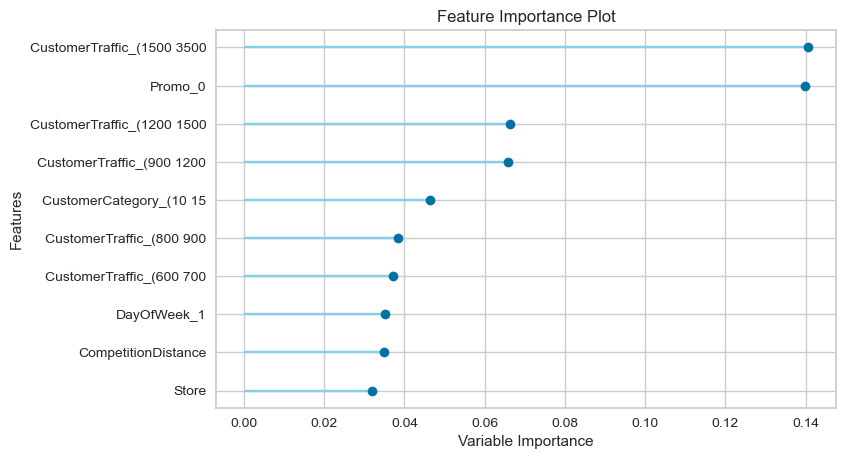

In [90]:
plot_model(rf, 'feature')

In [82]:
y_pred = rf_final.predict(combined_nopromo_processed_x_test)

In [83]:
def compute_rmse(actual, prediction):
    """
    Computs RMSE (root mean squared error) between predictions from a model
    and the actual values of the target variable.
    """
    rmse = sqrt(mean_squared_error(actual, prediction))
    # rounding to 2 decimal places
    print('RMSE is ', round(rmse,2))
    return rmse

In [84]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [85]:
random_forest_rmse = compute_rmse(combined_nopromo_processed_y_test, y_pred)

RMSE is  613.97


In [86]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])
metric(y_pred,combined_nopromo_processed_y_test.to_numpy())

9.649694533866807

### 2.2 Visualizations
Doing more visualizations to see which types of columns could be potentially helpful for us for predicting our target variable of price.

Looking at price spread by different levels of location information

In [237]:
avg_Sales_by_DayofWeek = data.groupby("DayOfWeek").mean()['Sales'].sort_values(ascending=False)
avg_Sales_by_promo = data.groupby('Promo').mean()['Sales'].sort_values(ascending=False)
avg_Sales_by_Assortment = data.groupby("Assortment").mean()['Sales'].sort_values(ascending=False)


In [238]:
avg_Sales_by_DayofWeek.describe().round()

count       7.0
mean     7143.0
std       841.0
min      5879.0
25%      6752.0
50%      7077.0
75%      7656.0
max      8225.0
Name: Sales, dtype: float64

In [239]:
avg_Sales_by_promo.describe().round()

count       2.0
mean     7083.0
std      1626.0
min      5934.0
25%      6508.0
50%      7083.0
75%      7658.0
max      8233.0
Name: Sales, dtype: float64

In [240]:
avg_Sales_by_Assortment.describe().round()

count       3.0
mean     7524.0
std      1025.0
min      6628.0
25%      6965.0
50%      7301.0
75%      7972.0
max      8643.0
Name: Sales, dtype: float64

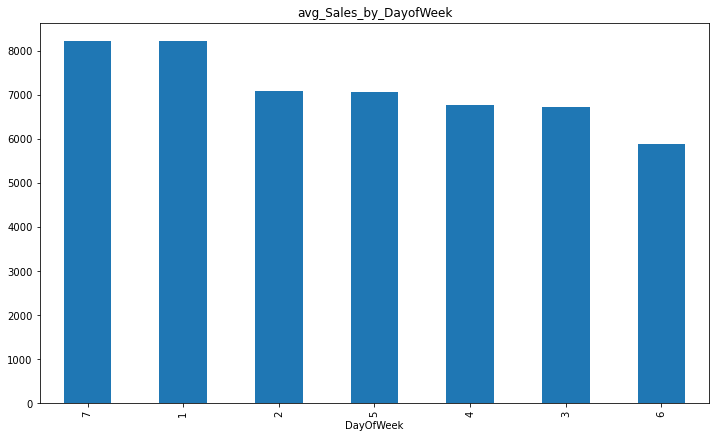

In [241]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(12,7))

avg_Sales_by_DayofWeek.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_DayofWeek')

fig;

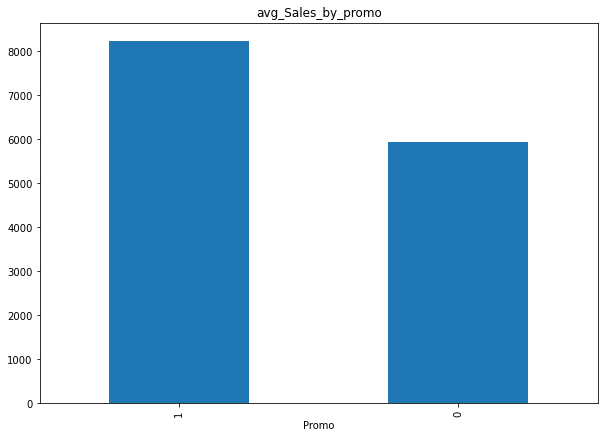

In [242]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(10,7))

avg_Sales_by_promo.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_promo')

fig;

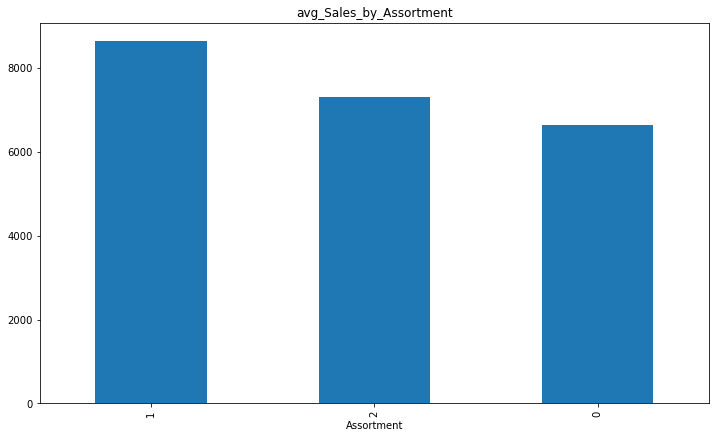

In [243]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(12,7))

avg_Sales_by_Assortment.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_Assortment')

fig;

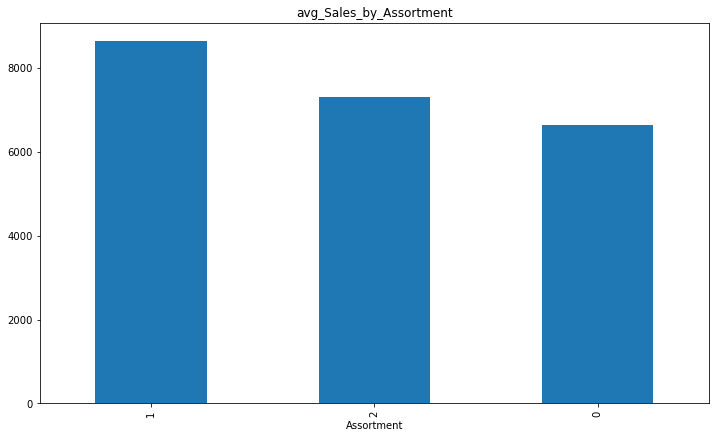

In [244]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, figsize=(12,7))

avg_Sales_by_Assortment.plot(ax=ax, kind='bar')

ax.set_title('avg_Sales_by_Assortment')

fig;

#### Seller Analysis
The "Store" column naming the store id who has the highest sales could be interesting. Maybe there is one "rock star" store who makes drastically more than the others. 

There is definitely a large spread between the agents. Some have an average sales that is one OOM larger than the others.

In [245]:
train_data.groupby("Store")["Sales"].mean().round().sort_values(ascending=False)

NameError: name 'train_data' is not defined

## 3. Feature Engineering

We have now seen that many of our categorical columns have a very large number of possible values (some with 200-300). 

This is too many to encoding using One Hot Encoding. 

So instead, we will use mean encoding, putting the average price for each of the potential category values as its new value.

**This helps us get all the columns to numeric format, for use in modelling!**

We will also drop "Address", since it is unique to the property and thus very unlikely to help our model learn.
For the location variables, we will just keep one.


All the rest we will mean encode, and then get started with modeling!

For this initial stage of modeling, we will also drop the column "Method".

In [160]:
data.head()

,Store,DayOfWeek,Sales,Customers_x,Promo,StateHoliday_1,StateHoliday_2,StateHoliday_3,StateHoliday_4,SchoolHoliday,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,DayofMonth,Year-original
0,1115.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,1.0,22.0,2012.0,3,5656.550582,1,4031.311408,2013
1,379.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2005.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013
2,378.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2012.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013
3,377.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,6.0,2010.0,1.0,18.0,2010.0,1,5656.550582,1,4031.311408,2013
4,376.0,2.0,0.0,0.0,0.0,1,0,0,0,1.0,...,8.0,2012.0,0.0,0.0,0.0,0,5656.550582,1,4031.311408,2013


In [161]:
label_encoder(data, ['StoreType','Assortment' ])

Now, nearly all of our columns are in numeric format, except for date. So, for this first round of modeling, we will also drop date. We can always pick it back up in the future.

Now all of our data is in numeric format! We can now start modeling. 

## 4. Initial Baseline Modeling

In [162]:
# splititng features and target back apart
x_train = train_data.copy(deep=True).drop(columns=["Sales"])
y_train = train_data.loc[:, "Sales"]

### Step 1: Lazy Estimator
Simply predicting the mean price for every house.

In [163]:
lazy_estimator_predictions = pd.DataFrame(y_train.copy())

# using median of entire training set
lazy_estimator_predictions.loc[:,'lazy_predicted_price'] = y_train.mean()
lazy_estimator_predictions.head().round()

,Sales,lazy_predicted_price
85986,4830.0,6839.0
630240,13137.0,6839.0
402540,7776.0,6839.0
113727,6018.0,6839.0
604918,4474.0,6839.0


With the lazy estimator, we are on average $639,810.92 dollars off in our predictions.

In [164]:
lazy_estimator_rmse = compute_rmse(y_train, lazy_estimator_predictions.loc[:, 'lazy_predicted_price'])

RMSE is  3083.72


### Step 2: Initial ML Model
Since this is a regression problem, we will start with linear regression as our model. 


In [256]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [261]:
x_train.drop(columns=['StoreType', 'Assortment'], inplace=True)
x_test.drop(columns=['StoreType', 'Assortment'], inplace=True)
CompetitionOpenSinceYear


In [363]:
# splitting data into features and targets 
x = data[data['Sales']!= 0].drop(columns=["Sales", "Customers_x"])
y = data[data['Sales']!= 0].loc[:, "Sales"].drop(columns=["Customers"])

# Removing 15% of data as holdout
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [364]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday_1', 'StateHoliday_2',
       'StateHoliday_3', 'StateHoliday_4', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [355]:
x_train = x_train[['Store', 'Year', 'Month',
       'Year-original','DayOfWeek', 'Promo', 'Promo2', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment','CompetitionOpenSinceMonth', 'Month',
       'DayofMonth']]
x_test= x_test[['Store', 'Year', 'Month',
       'Year-original','DayOfWeek', 'Promo', 'Promo2', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment','CompetitionOpenSinceMonth', 'Month',
       'DayofMonth']]

In [346]:
linear_regression_model = LinearRegression(normalize=True )
linear_regression_model.fit(x_train, y_train)
linear_regression_predictions = linear_regression_model.predict(x_test)

Just using a simple linear regression cut our RMSE almost in half over the lazy estimator!

In [347]:
linear_regression_rmse = compute_rmse(y_test, linear_regression_predictions)

RMSE is  1903.55


In [185]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday_1', 'StateHoliday_2',
       'StateHoliday_3', 'StateHoliday_4', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [200]:
combined[combined['Sales']==0].groupby('Open')['Sales'].value_counts().sort_values()

Open  Sales
1.0   0.0          40
0.0   0.0      102584
Name: Sales, dtype: int64

In [186]:
combined.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers_x', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CustomerTraffic', 'CustomerCategory',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [187]:
features2 = [ 'Store', 'DayOfWeek', 'Promo',
       'Year', 'Month', 'DayofMonth'       ]

In [188]:
x_train2= x_train[features2]
x_test2 = x_test[features2]


In [189]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train2, y_train)
linear_regression_predictions = linear_regression_model.predict(x_test2)

In [190]:
linear_regression_rmse = compute_rmse(y_test, linear_regression_predictions)

RMSE is  2809.63


### Step 3: More Sophisticated ML Model
We'll use a random forest, because it:
- is easy to implement
- gives feature importances
- can handle both integer and float values well

In [203]:
x_train.StateHoliday_2.value_counts()

1    351472
0       397
Name: StateHoliday_2, dtype: int64

In [212]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday_1', 'StateHoliday_2',
       'StateHoliday_3', 'StateHoliday_4', 'SchoolHoliday', 'CustomerTraffic',
       'CustomerCategory', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'DayofMonth', 'Year-original'],
      dtype='object')

In [381]:
x_train['Year-original'].value_counts()

2013    224522
2014    127347
Name: Year-original, dtype: int64

In [170]:
from sklearn.ensemble import RandomForestRegressor

In [378]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, np.log(y_train))


RandomForestRegressor()

In [382]:
random_forest_predictions = random_forest_model.predict(x_test)

In [388]:
random_forest_rmse = compute_rmse(y_test, np.exp(random_forest_predictions))

RMSE is  867.36


In [387]:
np.exp(random_forest_predictions)

array([7480.02527498, 8644.01611333, 7306.46846254, ..., 6994.53143612,
       9438.77616803, 3328.77181205])

Training an out-of-the-box random forest further decreased our RMSE.

In [389]:
metric(np.exp(random_forest_predictions),y_test.to_numpy())

13.786767501282277

In [362]:
filename = 'finalized_model.sav'
pickle.dump(random_forest_model, open(filename, 'wb'))

MemoryError: 

<AxesSubplot:>

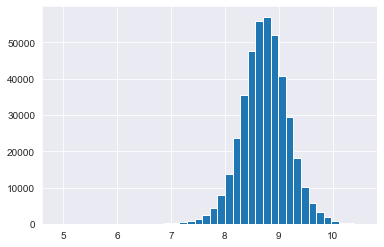

In [377]:
np.log(data[data['Sales']!=0].Sales).hist(bins=40)

<AxesSubplot:>

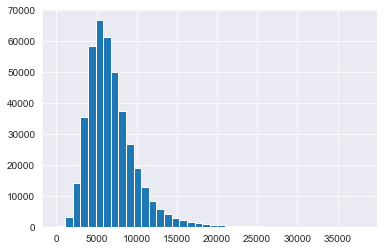

In [390]:
data[data['Sales']!=0].Sales.hist(bins=40)

In [391]:
data


MemoryError: Unable to allocate 26.7 MiB for an array with shape (7, 499419) and data type float64

MemoryError: Unable to allocate 26.7 MiB for an array with shape (7, 499419) and data type float64